In [1]:
CUDA_INDEX = 3
NAME = 'Protein'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}-FS2/outer_pred.pt', map_location='cpu')),
    ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}-FS2/nn_outer_pred.pt', map_location='cpu')),
    ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}-FS2/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}-FS2/nm_outer_pred.npy'))),
#     ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}-FS2/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}-FS2/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}-FS2/f2_outer_pred.pt', map_location='cpu')),
]

In [5]:
outer_test_set = torch.load(f'../data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

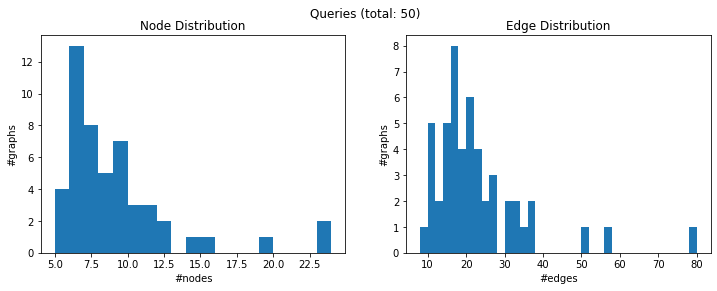

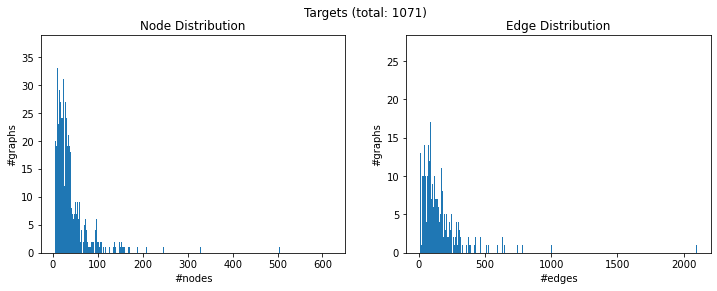

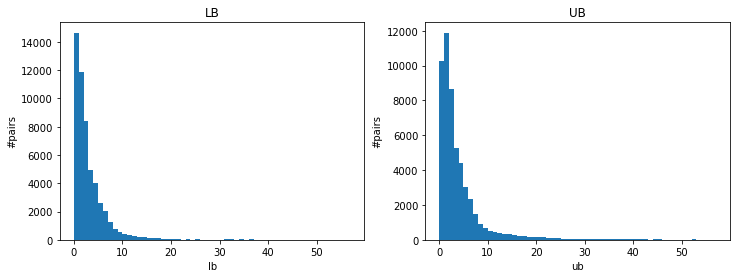

In [6]:
viz.plot_dataset_dist(outer_test_set)

In [7]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

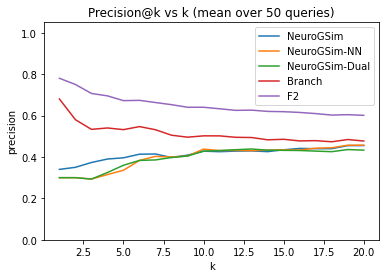

34.00 / 39.60 / 42.80 / 43.47 / 45.50
30.00 / 33.60 / 43.80 / 43.47 / 45.70
30.00 / 36.00 / 42.80 / 43.20 / 43.30
68.00 / 53.20 / 50.20 / 48.53 / 47.70
78.00 / 67.20 / 64.00 / 61.87 / 60.10


In [8]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [9]:
for label, pred in preds:
#     print(f'{label}', end='\n')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([20]), lb[:5], ub[:5], pred[:5])).item()
    print(f'{tmp*100:.2f}')
#     print()

83.37
84.21
87.37
69.47
71.16


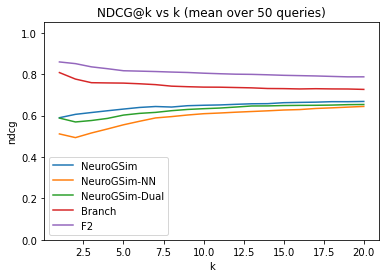

58.95 / 63.13 / 64.97 / 66.20 / 66.81
51.13 / 55.54 / 60.89 / 62.67 / 64.40
58.78 / 60.22 / 63.31 / 64.83 / 65.34
80.75 / 75.66 / 73.73 / 73.00 / 72.63
85.89 / 81.63 / 80.46 / 79.43 / 78.70


In [10]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG@k vs k (mean over {len(queries)} queries)')

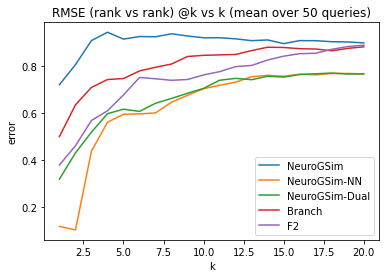

0.720 / 0.913 / 0.919 / 0.894 / 0.897
0.120 / 0.595 / 0.703 / 0.756 / 0.766
0.320 / 0.616 / 0.705 / 0.752 / 0.766
0.500 / 0.746 / 0.844 / 0.878 / 0.880
0.380 / 0.677 / 0.761 / 0.841 / 0.887


In [11]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

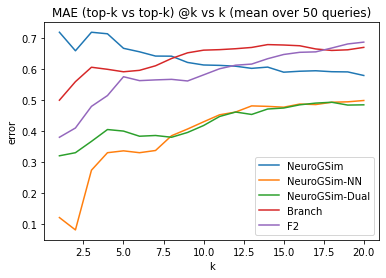

0.720 / 0.668 / 0.614 / 0.591 / 0.580
0.120 / 0.336 / 0.430 / 0.477 / 0.499
0.320 / 0.400 / 0.418 / 0.475 / 0.485
0.500 / 0.592 / 0.662 / 0.679 / 0.671
0.380 / 0.576 / 0.582 / 0.648 / 0.688


In [12]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)